In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.ndimage import laplace
from findiff import Diff

In [2]:
# make sure you are in the ddmp-flax repo 
import os
#show the current working directory
os.getcwd()
#change the current working directory to 'd:\\diffusion model\\TEST3\\denoising-diffusion-flax-20250107T081638Z-001\\denoising-diffusion-flax\\denoising_diffusion_flax'
os.chdir('d:\\diffusion model\\TEST4\\denoising-diffusion-flax-20250107T081638Z-001\\denoising-diffusion-flax-v5-LC\\get_training_data\\v2')
#show the current working directory
os.getcwd()

'd:\\diffusion model\\TEST4\\denoising-diffusion-flax-20250107T081638Z-001\\denoising-diffusion-flax-v5-LC\\get_training_data\\v2'

In [3]:
def relaxation(N1, N2, Azi,t_max):
    gamma = 2
    Seq = np.sqrt(2)/gamma
    sigma = 0.1

    Qxx = Seq * np.cos(Azi*2)
    Qxy = Seq * np.sin(Azi*2)


    
    for t in range(t_max):
        del2Qxx = laplace(Qxx)
        del2Qxy = laplace(Qxy)
        thermoQxx = (1/gamma**2) * Qxx - 2 * (Qxx**2 + Qxy**2) * Qxx
        thermoQxy = (1/gamma**2) * Qxy - 2 * (Qxx**2 + Qxy**2) * Qxy
        dQxxdt = del2Qxx + thermoQxx
        dQxydt = del2Qxy + thermoQxy
        Qxx = Qxx + dQxxdt * sigma
        Qxy = Qxy + dQxydt * sigma
    Q = np.stack((Qxx, Qxy), axis=-1)
    return Q

In [4]:
def relaxationBC(N1, N2, Azi, t_max,    
    ywallbottom_angle=np.pi,
    ywalltop_angle=np.pi,
    xwallleft_angle=np.pi,
    xwallright_angle=np.pi,     
    ywalltop_anchoring=0,
    ywallbottom_anchoring=0,
    xwallleft_anchoring=0,
    xwallright_anchoring=0):
    # output_fig = 200
    # t_max = 2000
    gamma = 2
    Seq = np.sqrt(2)/gamma
    sigma = 0.1
    




    Qxx = Seq * np.cos(Azi*2)
    Qxy = Seq * np.sin(Azi*2)


    # generate index to differentiate between the interior and the boundary
    interior = np.ones((N2, N1))
    interior[0, :] = 0
    interior[-1, :] = 0
    interior[:, 0] = 0
    interior[:, -1] = 0
    boundary = np.zeros((N2,N1))
    boundary[0, :] = 1
    boundary[-1, :] = 1
    boundary[:, 0] = 1
    boundary[:, -1] = 1

    # generate normal vector for the boundary
    vx = np.zeros((N2, N1))
    vy = np.zeros((N2, N1))

    # y = 0 not include x=0 and x=L1 v=[0,-1]  ywallbottom
    vy[0, 1:-1] = -1 
    # y = L2 v=[0,1] ywalltop
    vy[-1, 1:-1] = 1
    # x = 0 v=[-1,0] xwallleft
    vx[:, 0] = -1
    # x = L1 v=[1,0] xwallright
    vx[:, -1] = 1


    # defined prefer Q_0
    Azi_prefer = np.zeros((N2,N1))
    Azi_prefer[0,:]=ywallbottom_angle
    Azi_prefer[-1,:]=ywalltop_angle
    Azi_prefer[:,0]=xwallleft_angle
    Azi_prefer[:,-1]=xwallright_angle

    Qxx_0 = Seq * np.cos(Azi_prefer*2) * boundary
    Qxy_0 = Seq * np.sin(Azi_prefer*2) * boundary


    #anchoring strength of different wall
    W = boundary
    W[:,0]=xwallleft_anchoring
    W[:,-1]=xwallright_anchoring
    W[0,:]=ywallbottom_anchoring
    W[-1,:]=ywalltop_anchoring



    for t in range(t_max):


        # calculate Q gradient
        d_dx = Diff(1, 1,acc=2)
        d_dy = Diff(0, 1,acc=2)
        laplacian = d_dx**2+d_dy**2
        dxdQxx = d_dx(Qxx)
        dydQxx = d_dy(Qxx)
        dxdQxy = d_dx(Qxy)
        dydQxy = d_dy(Qxy)
        del2Qxx = laplacian(Qxx)
        del2Qxy = laplacian(Qxy)
        assert not np.isnan(dxdQxx).any()
        assert not np.isnan(dxdQxy).any()
        thermoQxx = (1/gamma**2) * Qxx - 2 * (Qxx**2 + Qxy**2) * Qxx
        thermoQxy = (1/gamma**2) * Qxy - 2 * (Qxx**2 + Qxy**2) * Qxy
        dQxxdt_bulk = del2Qxx + thermoQxx
        dQxydt_bulk = del2Qxy + thermoQxy
        # evolve interior Q
        dQxxdt_bulk *= interior
        dQxydt_bulk *= interior
        # evolve boundary Q
        dQxxdt_surf = (dxdQxx * vx + dydQxx * vy) + W*(Qxx*boundary-Qxx_0*boundary)
        dQxydt_surf = (dxdQxy * vx + dydQxy * vy) + W*(Qxy*boundary-Qxy_0*boundary)

        dQxxdt = dQxxdt_bulk - dQxxdt_surf
        dQxydt = dQxydt_bulk - dQxydt_surf
        assert not np.isnan(dQxxdt).any()
        assert not np.isnan(dQxydt).any()
        Qxx = Qxx + dQxxdt * sigma
        Qxy = Qxy + dQxydt * sigma
    Q = np.stack((Qxx, Qxy), axis=-1)
    return Q

In [7]:
Qxxtotal = []
Qxytotal = []

Generate non-defect

In [21]:

import pandas as pd
print(np.array(Qxxtotal).shape) 
print(np.array(Qxytotal).shape)
# 保存前查看前几行数据
df1 = pd.DataFrame(Qxxtotal)
df2 = pd.DataFrame(Qxytotal)
# print("DataFrame 前 5 行:\n", df)
# 保存数据
df1.to_csv('Qxx_data.csv', index=False, header=False)
df2.to_csv('Qxy_data.csv', index=False, header=False)
# 打开数据
data = pd.read_csv('Qxx_data.csv', header=None)
data2 = pd.read_csv('Qxy_data.csv', header=None)
# # print("打开的数据:\n", data)
# print("打开的数据类型:\n", type(data))
# # data是一个DataFrame类型，可以通过.values转换为numpy数组
# data = data.values
print("打开的数据形状:\n", data.shape)
print("打开的数据形状:\n", data2.shape)
# 删除数据
# os.remove('Qxx_data.csv')


(4320, 4096)
(4320, 4096)
打开的数据形状:
 (4320, 4096)
打开的数据形状:
 (4320, 4096)


Generate single defect

(64, 64)


Processing angles: 100%|██████████| 720/720 [07:41<00:00,  1.56it/s]


(2160, 4096)


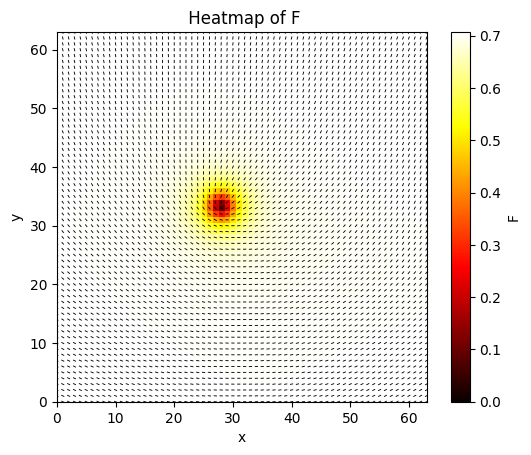

In [ ]:


# Initial condition
# Initial mesh grid
N1 = 64
L1 = 64
N2 = 64
L2 = 64

dx = L1 / N1
dy = L2 / N2

x, y = np.meshgrid(np.arange(0, L1, dx), np.arange(0, L2, dy))
print(x.shape)
Azi = np.zeros_like(x) * np.pi - np.pi / 2

import tqdm
angle = (np.arange(0,180,0.25))
defect_position = (np.arange(-1,2,1))
for angle_i in tqdm.tqdm(angle, desc="Processing angles"):
    for defect_positionx_i in tqdm.tqdm(defect_position, desc="Processing defect positions", leave=False):

        defect_positionx = [59, 32+np.random.randint(-10,10)]
        defect_positiony = [32, 32+np.random.randint(-10,10)]
        defect_charge = [0, 0.5*defect_positionx_i]
        defect_phase = np.array([90, 0]+angle_i) * np.pi / 180
        defect_orientation = 0 * np.pi / 6

        # Calculate defect positions
        Pdefect_positionx = x[0, int(defect_positionx[0]) + 3] + (defect_positionx[0] - int(defect_positionx[0])) * dx
        Pdefect_positiony = y[int(defect_positiony[0]) + 3, 0] + (defect_positiony[0] - int(defect_positiony[0])) * dy
        Mdefect_positionx = x[0, int(defect_positionx[1]) + 3] + (defect_positionx[1] - int(defect_positionx[1])) * dx
        Mdefect_positiony = y[int(defect_positiony[1]) + 3, 0] + (defect_positiony[1] - int(defect_positiony[1])) * dy

        # Plot properties
        vector_length = 1
        vector_width = 1
        vector_color = 'black'

        Azi_temp = np.zeros((N2, N1))

        x_defect_distance = defect_positionx[0] - defect_positionx[1]
        y_defect_distance = defect_positiony[0] - defect_positiony[1]
        dr = (x_defect_distance**2 + y_defect_distance**2)
        del_theta = (defect_phase[1] - defect_phase[0] + defect_charge[1] * np.arctan2(y_defect_distance, x_defect_distance) - defect_charge[0] * np.arctan2(-y_defect_distance, -x_defect_distance))
        L_theta = defect_phase[0] - defect_charge[1] * np.arctan2(y_defect_distance, x_defect_distance)

        for i in range(N1):
            for j in range(N2):
                x_distance1 = i - defect_positionx[0]
                y_distance1 = j - defect_positiony[0]
                x_distance2 = i - defect_positionx[1]
                y_distance2 = j - defect_positiony[1]
                dr1 = (x_distance1**2 + y_distance1**2)
                dr2 = (x_distance2**2 + y_distance2**2)
                if dr1 <= 0.1:
                    dr1 = 0.1
                if dr2 <= 0.1:
                    dr2 = 0.1
                ph1 = np.arctan2(y_distance1, x_distance1)
                ph2 = np.arctan2(y_distance2, x_distance2)

                Azi_temp[j, i] = (ph1 * defect_charge[0] + ph2 * defect_charge[1] + 0.5 * del_theta * (1 + (np.log(dr1) - np.log(dr2)) / np.log(dr)) + L_theta)

        Azi = Azi_temp + np.random.normal(0, 0.02, Azi_temp.shape)
        Layer = relaxationBC(N1, N2, Azi, 300)
        Qxxtotal.append(Layer[:,:,0].flatten())
        Qxytotal.append(Layer[:,:,1].flatten())
        # file_name = 'minus'+str(angle_i)+'.npy'
        # # file_name = 'plus'+str(angle_i)+'.npy'  
        # np.save(file_name, Layer)
print(np.array(Qxxtotal).shape)
Qxx = Layer[:,:,0]
Qxy = Layer[:,:,1]
nx = np.zeros((N2,N1))
ny = np.zeros((N2,N1))
S = np.zeros((N2,N1))

for i in range(N2):
    for j in range(N1):
        matrix = np.array([[Qxx[i, j], Qxy[i, j]],
                        [Qxy[i, j], -Qxx[i, j]]])
        vals, vecs = np.linalg.eigh(matrix)
        index = np.argmax(vals)
        nx[i,j] = vecs[0, index]
        ny[i,j] = vecs[1, index]
        S[i,j] = vals[index]*2
plt.figure(figsize=(10, 10))
plt.imshow(S, cmap='hot', interpolation='nearest', origin='lower', extent=[x.min(), x.max(), y.min(), y.max()], vmin=0, vmax=0.707)
plt.colorbar(label='F')  # Add a colorbar to show the scale
plt.title(' Heatmap of F')
plt.xlabel('x')
plt.ylabel('y')
plt.quiver(x, y, nx, ny, color='black', scale=100, headlength=0, headaxislength=0, headwidth=0, pivot='middle')
plt.show() 


In [ ]:
Qxxtotal = np.array(Qxxtotal)
Qxytotal = np.array(Qxytotal)
Qxxtotal1 = Qxxtotal[:2160,:]
Qxytotal1 = Qxytotal[:3500,:]
print(Qxxtotal1.shape)
# convert back to list
Qxxtotal1 = Qxxtotal1.tolist()
Qxytotal1 = Qxytotal1.tolist()
Qxxtotal = Qxxtotal.tolist()
Qxytotal = Qxytotal.tolist()
print(np.array(Qxxtotal1).shape)

(2160, 4096)
(2160, 4096)


Generate multiple defects

(64, 64)


Processing angles: 100%|██████████| 360/360 [02:40<00:00,  2.24it/s]


(4320, 4096)


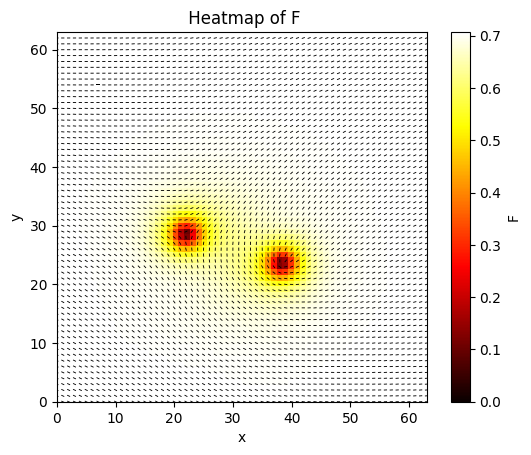

In [ ]:


# Initial condition
# Initial mesh grid
N1 = 64
L1 = 64
N2 = 64
L2 = 64

dx = L1 / N1
dy = L2 / N2

x, y = np.meshgrid(np.arange(0, L1, dx), np.arange(0, L2, dy))
print(x.shape)
Azi = np.zeros_like(x) * np.pi - np.pi / 2

import tqdm
angle = (np.arange(0,180,0.5))
defect_position = (np.arange(1,4,1))
for angle_i in tqdm.tqdm(angle, desc="Processing angles"):
    for defect_positionx_i in tqdm.tqdm(defect_position, desc="Processing defect positions", leave=False):

        defect_positionx = [44+np.random.randint(-10,10), 20+np.random.randint(-10,10)]
        defect_positiony = [32+np.random.randint(-10,10), 32+np.random.randint(-10,10)]
        defect_charge = [0.5, -0.5]
        defect_phase = np.array([90, 0]+angle_i) * np.pi / 180
        defect_orientation = 0 * np.pi / 6

        # Calculate defect positions
        Pdefect_positionx = x[0, int(defect_positionx[0]) + 3] + (defect_positionx[0] - int(defect_positionx[0])) * dx
        Pdefect_positiony = y[int(defect_positiony[0]) + 3, 0] + (defect_positiony[0] - int(defect_positiony[0])) * dy
        Mdefect_positionx = x[0, int(defect_positionx[1]) + 3] + (defect_positionx[1] - int(defect_positionx[1])) * dx
        Mdefect_positiony = y[int(defect_positiony[1]) + 3, 0] + (defect_positiony[1] - int(defect_positiony[1])) * dy

        # Plot properties
        vector_length = 1
        vector_width = 1
        vector_color = 'black'

        Azi_temp = np.zeros((N2, N1))

        x_defect_distance = defect_positionx[0] - defect_positionx[1]
        y_defect_distance = defect_positiony[0] - defect_positiony[1]
        dr = (x_defect_distance**2 + y_defect_distance**2)
        del_theta = (defect_phase[1] - defect_phase[0] + defect_charge[1] * np.arctan2(y_defect_distance, x_defect_distance) - defect_charge[0] * np.arctan2(-y_defect_distance, -x_defect_distance))
        L_theta = defect_phase[0] - defect_charge[1] * np.arctan2(y_defect_distance, x_defect_distance)

        for i in range(N1):
            for j in range(N2):
                x_distance1 = i - defect_positionx[0]
                y_distance1 = j - defect_positiony[0]
                x_distance2 = i - defect_positionx[1]
                y_distance2 = j - defect_positiony[1]
                dr1 = (x_distance1**2 + y_distance1**2)
                dr2 = (x_distance2**2 + y_distance2**2)
                if dr1 <= 0.1:
                    dr1 = 0.1
                if dr2 <= 0.1:
                    dr2 = 0.1
                ph1 = np.arctan2(y_distance1, x_distance1)
                ph2 = np.arctan2(y_distance2, x_distance2)

                Azi_temp[j, i] = (ph1 * defect_charge[0] + ph2 * defect_charge[1] + 0.5 * del_theta * (1 + (np.log(dr1) - np.log(dr2)) / np.log(dr)) + L_theta)

        Azi = Azi_temp + np.random.normal(0, 0.02, Azi_temp.shape)
        Layer = relaxationBC(N1, N2, Azi, 200)
        Qxxtotal.append(Layer[:,:,0].flatten())
        Qxytotal.append(Layer[:,:,1].flatten())
        # file_name = 'Twodefect'+str(angle_i)+str(defect_positionx_i)+'.npy'  
        # np.save(file_name, Layer)
print(np.array(Qxxtotal).shape)
Qxx = Layer[:,:,0]
Qxy = Layer[:,:,1]
nx = np.zeros((N2,N1))
ny = np.zeros((N2,N1))
S = np.zeros((N2,N1))

for i in range(N2):
    for j in range(N1):
        matrix = np.array([[Qxx[i, j], Qxy[i, j]],
                        [Qxy[i, j], -Qxx[i, j]]])
        vals, vecs = np.linalg.eigh(matrix)
        index = np.argmax(vals)
        nx[i,j] = vecs[0, index]
        ny[i,j] = vecs[1, index]
        S[i,j] = vals[index]*2
plt.figure(figsize=(10, 10))
plt.imshow(S, cmap='hot', interpolation='nearest', origin='lower', extent=[x.min(), x.max(), y.min(), y.max()], vmin=0, vmax=0.707)
plt.colorbar(label='F')  # Add a colorbar to show the scale
plt.title(' Heatmap of F')
plt.xlabel('x')
plt.ylabel('y')
plt.quiver(x, y, nx, ny, color='black', scale=100, headlength=0, headaxislength=0, headwidth=0, pivot='middle')
plt.show() 

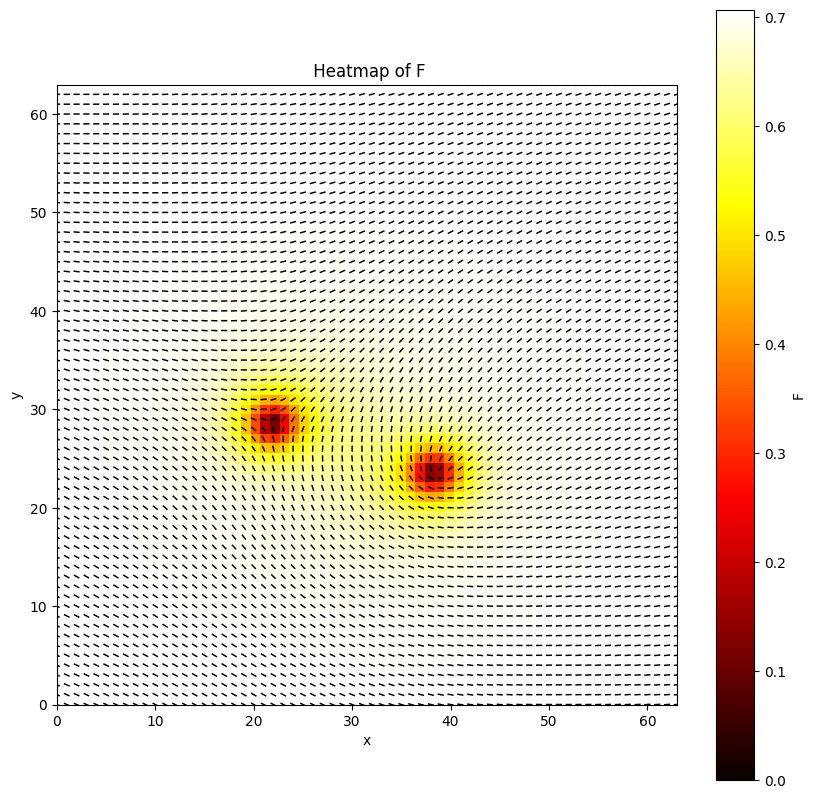

In [17]:
Qxx = Layer[:,:,0]
Qxy = Layer[:,:,1]
nx = np.zeros((N2,N1))
ny = np.zeros((N2,N1))
S = np.zeros((N2,N1))

for i in range(N2):
    for j in range(N1):
        matrix = np.array([[Qxx[i, j], Qxy[i, j]],
                        [Qxy[i, j], -Qxx[i, j]]])
        vals, vecs = np.linalg.eigh(matrix)
        index = np.argmax(vals)
        nx[i,j] = vecs[0, index]
        ny[i,j] = vecs[1, index]
        S[i,j] = vals[index]*2
plt.figure(figsize=(10, 10))
plt.imshow(S, cmap='hot', interpolation='nearest', origin='lower', extent=[x.min(), x.max(), y.min(), y.max()], vmin=0, vmax=0.707)
plt.colorbar(label='F')  # Add a colorbar to show the scale
plt.title(' Heatmap of F')
plt.xlabel('x')
plt.ylabel('y')
plt.quiver(x, y, nx, ny, color='black', scale=100, headlength=0, headaxislength=0, headwidth=0, pivot='middle')
plt.show() 